In [1]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageEnhance
import imageio
import seaborn as sns
from natsort import natsorted
from scipy.ndimage import gaussian_filter1d


## Import relevant libraries
import sys
sys.path.append('../../activedrops')
import pivdrops
pivdrops.set_plotting_style()

C:\Users\dalar\AppData\Local\Temp\ipykernel_27568\2290824246.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(tif_files[0]) / (2**16)


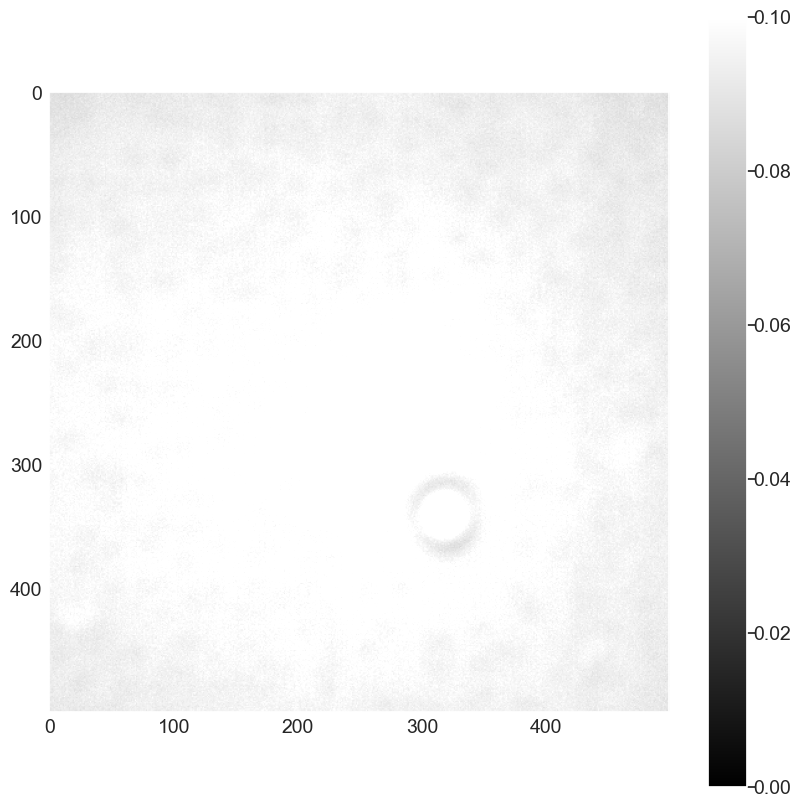

In [4]:
tif_files = sorted(glob.glob('../../data/MTs_mVenus-calibration/MT_late/Pos1/img_0000000**_cy5-4x_000.tif'))

# Load the first image & normalize the pixel values to 0-1
im = imageio.imread(tif_files[0]) / (2**16) 

im = im[750:1250, 750:1250]

# visualize the grid of pixel values with a heatmap size 10x10
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='gray', vmin=0, vmax=0.1)  # Set vmin and vmax to define the colorbar scale
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)  # Set colorbar tick font size
plt.xticks(fontsize=14)  # Set x-axis tick font size
plt.yticks(fontsize=14)  # Set y-axis tick font size
plt.show()


In [ ]:
tif_files = sorted(glob.glob('../../data/030524-kif3-stirring/DNA80nM_MT/Pos2/original/img_00000****_cy5-4x_000.tif'))

# Load the first image
im = imageio.imread(tif_files[2]) 

# visualize the grid of pixel values with a heatmap size 10x10
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='gray', vmin=0, vmax=2**16 / 8)  # Set vmin and vmax to define the colorbar scale
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)  # Set colorbar tick font size
plt.xticks(fontsize=14)  # Set x-axis tick font size
plt.yticks(fontsize=14)  # Set y-axis tick font size
plt.show()


In [ ]:
def convert_cy5_gfp_to_8bit(data_path, conditions, subconditions, min_frame, max_frame):
    """
    Converts CY5 and GFP TIFF images to 8-bit format for all combinations of conditions and subconditions.

    Parameters:
    - data_path (str): Base path where the images are stored.
    - conditions (list of str): List of condition names.
    - subconditions (list of str): List of subcondition names.
    - min_frame (int): Minimum frame number to process.
    - max_frame (int): Maximum frame number to process.
    """
    for condition in conditions:
        for subcondition in subconditions:
            # Directories for original and converted images
            directory = os.path.join(data_path, condition, subcondition,)
            cy5_output_directory = os.path.join(data_path, condition, subcondition, "cy5_8bit")
            gfp_output_directory = os.path.join(data_path, condition, subcondition, "gfp_8bit")

            # Create the output directories if they don't exist
            os.makedirs(cy5_output_directory, exist_ok=True)
            os.makedirs(gfp_output_directory, exist_ok=True)

            # Pattern to match .tif files
            search_pattern = os.path.join(directory, "img_*.tif")

            # Get a sorted list of all .tif files to ensure they are processed in order
            tif_files = sorted(glob.glob(search_pattern))[min_frame:max_frame]

            for tif_file in tif_files:
                try:
                    # Read the image using imageio and normalize it given that it's 16bit and we are going to convert it to 8bit
                    img = imageio.imread(tif_file) 

                    # Convert the image to 8-bit
                    # img_8bit = img # (img).astype('uint16')

                    # Extract the base name
                    base_name = os.path.basename(tif_file)

                    # Determine the output directory based on the file name
                    if "cy5" in base_name:
                        output_directory = cy5_output_directory
                    elif "gfp" in base_name:
                        output_directory = gfp_output_directory
                    else:
                        continue  # Skip files that do not match 'cy5' or 'gfp'

                    # Generate the new file path in the appropriate '8bit' folder
                    new_file_path = os.path.join(output_directory, base_name)

                    # Save the 8-bit image using imageio
                    imageio.imwrite(new_file_path, img)
                except Exception as e:
                    print(f"Error processing {tif_file}: {e}")


In [ ]:
# Example usage
data_path = "../../data/MTs_mVenus-calibration/"
conditions = ["gfp"]
subconditions = ["Pos0", "Pos1", "Pos2", "Pos3", "Pos4", "Pos5", "Pos6", "Pos7"]
min_frame = 0
max_frame = None

# convert_cy5_gfp_to_8bit(data_path, conditions, subconditions, min_frame, max_frame)



In [ ]:
def plot_mean_fluorescence_over_time(data_path, conditions, subconditions, channel, time_interval=3, min_frame=0, max_frame=None, skip_frames=1, log_scale=False):
    """
    Computes and plots the mean fluorescence intensity over time for a given set of images across multiple conditions and subconditions,
    with visual grouping by condition and improved legend. Time is displayed in hours. The final plot, including all curves, is saved as a JPG file.

    Parameters:
    - data_path (str): Base path where the images are stored.
    - conditions (list of str): List of condition names.
    - subconditions (list of str): List of subcondition names.
    - channel (str): Channel name.
    - time_interval (int): Time interval between frames in minutes.
    - min_frame (int): Minimum frame number to process.
    - max_frame (int): Maximum frame number to process.
    - skip_frames (int): Number of frames to skip between plotted points.
    - log_scale (bool): Whether to plot the y-axis in log scale.
    """
    plt.figure(figsize=(12, 8))

    # Use a colormap to generate distinct colors for each condition
    cmap = plt.get_cmap('viridis')
    condition_colors = cmap(np.linspace(0, 1, len(conditions)))

    # Generate shades for subconditions within each condition
    for condition_idx, condition in enumerate(conditions):
        base_color = condition_colors[condition_idx]
        
        for sub_idx, subcondition in enumerate(subconditions):
            directory_path = os.path.join(data_path, condition, subcondition, )
            image_files = sorted(glob.glob(os.path.join(directory_path, "*.tif")))[min_frame:max_frame:skip_frames]
            
            intensities = []
            frames = []
            
            for i, image_file in enumerate(image_files):
                img = imageio.imread(image_file)
                mean_intensity = np.mean(img)
                frames.append(i * skip_frames)  # Adjust frames slightly for visual separation
                intensities.append(mean_intensity)
            
            results_df = pd.DataFrame({
                "frame": frames,
                "mean_intensity": intensities # - np.min(intensities)
            })
            
            # Apply Gaussian filter to mean_intensity for smoothing
            smoothed_intensities = gaussian_filter1d(results_df["mean_intensity"], sigma=2)  # Sigma controls the smoothing strength
            
            # Calculate shade for subcondition
            alpha = 0.3 + (sub_idx / len(subconditions)) * 0.7  # Adjust alpha for subcondition shading
            color = base_color * np.array([1, 1, 1, alpha])

            # Plot each condition and subcondition with smoothed data
            plt.plot(results_df["frame"] * time_interval / 60 / 60, smoothed_intensities, color=color, marker='o', linestyle='-', label=f"{condition} - {subcondition}")

    plt.title(f"Fluorescence expression over time - {channel}")
    plt.xlabel("Time (hours)")
    plt.ylabel("Normalized Mean Fluorescence Intensity (A.U.)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()

    if log_scale:
        plt.yscale('log')  # Set y-axis scale to log scale

    # Determine the output path for saving the plot
    output_path = os.path.join(data_path, f"{channel}_mean_fluorescence_vs_time.jpg")
    plt.savefig(output_path, format='jpg', dpi=300)
    plt.close()  # Close the figure after saving to free resources

# Call the function with the updated parameters
plot_mean_fluorescence_over_time(
    data_path=data_path,
    conditions=conditions,
    subconditions=subconditions,
    channel="gfp",
    time_interval=1,  
    min_frame=0,
    max_frame=None,
    skip_frames=1,
    log_scale=False  # Set log_scale parameter to True to plot in log scale
)


In [ ]:
def create_normalized_intensity_heatmap(data_path, condition, subcondition, channel, time_interval=3, min_frame=0, max_frame=None, vmax=None, skip_frames=1):
    """
    Reads each image as a matrix, creates and saves a heatmap representing the normalized pixel-wise fluorescence intensity.

    Args:
    - data_path (str): Base directory where the images are stored.
    - condition (str): Condition defining a subdirectory within the data path.
    - subcondition (str): Subcondition defining a further subdirectory.
    - channel (str): Channel specifying the fluorescence ('cy5' or 'gfp').
    - time_interval (int): Time interval in seconds between frames.
    - min_frame (int): Minimum frame number to start processing from.
    - max_frame (int, optional): Maximum frame number to stop processing at.
    """
    # Determine the directory paths based on the channel
    input_directory_path = os.path.join(data_path, condition, subcondition, f"{channel}_8bit")
    output_directory_path = os.path.join(data_path, condition, subcondition, "intensity_heatmap")
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)

    # Get all .tif files in the folder
    image_files = sorted(glob.glob(os.path.join(input_directory_path, "*.tif")))[min_frame:max_frame:skip_frames] 
    
    # Loop through each image file and create a heatmap
    for i, image_file in enumerate(image_files, start=min_frame):
        # Read the image into a numpy array
        intensity_matrix = imageio.imread(image_file) 

        # Plot the heatmap
        fig, ax = plt.subplots(figsize=(8, 8))
        im = ax.imshow(intensity_matrix, cmap='gray', interpolation='nearest', extent=[-2762/2, 2762/2, -2762/2, 2762/2], vmin=0, vmax=vmax)
        plt.colorbar(im, ax=ax, label='Normalized Fluorescence Intensity (A.U.)')
        plt.title(f"Time (min): {(i - min_frame) * time_interval / 60:.2f}. \n{condition} - {subcondition} - {channel}")
        plt.xlabel('x [um]')
        plt.ylabel('y [um]')
        
        # Save the heatmap
        heatmap_filename = f"heatmap_frame_{i}.tif"
        heatmap_path = os.path.join(output_directory_path, heatmap_filename)
        plt.savefig(heatmap_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
        plt.close(fig)  # Close the figure to free memory
 

In [ ]:
create_normalized_intensity_heatmap(data_path, conditions[0], subconditions[0], "cy5", time_interval=1, min_frame=0, max_frame=None, vmax=2**16 / 4)

In [ ]:
def create_annotated_image_movies(data_path, condition, subcondition, channel, frame_rate=30, max_frame=None):
    """
    Creates video files from processed and annotated images stored in a specified directory.

    Args:
    - data_path (str): Base path where the annotated images are stored.
    - condition (str): Condition under which the annotated images are stored.
    - subcondition (str): Subcondition under which the annotated images are stored.
    - channel (str): The specific channel being processed ('cy5' or 'gfp').
    - frame_rate (int, optional): Frame rate for the output video. Defaults to 30.
    - max_frame (int, optional): Maximum number of frames to be included in the video. If None, all frames are included.
    """


    images_dir = os.path.join(data_path, condition, subcondition, "intensity_heatmap")

    image_files = natsorted(glob.glob(os.path.join(images_dir, "*.tif")))

    if max_frame is not None:
        image_files = image_files[:max_frame]

    if not image_files:
        print("No images found for video creation.")
        return

    # Get the resolution of the first image (assuming all images are the same size)
    first_image = cv2.imread(image_files[0])
    video_resolution = (first_image.shape[1], first_image.shape[0])  # Width x Height

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out_path = os.path.join(data_path, condition, subcondition, f"{channel}_movie.avi")
    out = cv2.VideoWriter(out_path, fourcc, frame_rate, video_resolution)

    for file_path in image_files:
        img = cv2.imread(file_path)
        out.write(img)  # Write the image frame to the video

    out.release()
    print(f"Video saved to {out_path}")


In [ ]:
def process_all_conditions_and_subconditions(data_path, conditions, subconditions, channel, time_interval, skip_frames, vmax, frame_rate):
    """
    Wrapper function to create heatmaps and movies for all combinations of conditions and subconditions.

    Args:
    - data_path (str): Base directory where the images are stored.
    - conditions (list of str): List of condition names.
    - subconditions (list of str): List of subcondition names.
    - channel (str): Channel specifying the fluorescence ('cy5' or 'gfp').
    - time_interval (int): Time interval in seconds between frames for heatmap.
    - skip_frames (int): Number of frames to skip between each processed frame for heatmap.
    - vmax (int): Maximum value for normalization in the heatmap.
    - frame_rate (int): Frame rate for the output video.
    """
    for condition in conditions:
        for subcondition in subconditions:
            # Create heatmaps for each condition and subcondition
            create_normalized_intensity_heatmap(
                data_path=data_path,
                condition=condition,
                subcondition=subcondition,
                channel=channel,
                time_interval=time_interval,
                min_frame=min_frame,
                max_frame=max_frame,
                vmax=vmax,
                skip_frames=skip_frames
            )
            
            # Create annotated image movies for each condition and subcondition
            create_annotated_image_movies(
                data_path=data_path,
                condition=condition,
                subcondition=subcondition,
                channel=channel,
                frame_rate=frame_rate,
                max_frame=max_frame
            )



process_all_conditions_and_subconditions(
    data_path=data_path,
    conditions=conditions,
    subconditions=subconditions,
    channel="cy5",
    time_interval=60,  # Adjust as needed
    skip_frames=1,
    vmax=13000,  # Adjust as needed
    frame_rate=120  # Adjust as needed
)
